# Neurocontrol with RNNs


## IADS Summer School, 2nd August 2022

### Dr Michael Fairbank, University of Essex, UK

- Email: m.fairbank@essex.ac.uk
- This is Jupyter Notebook 4.1 of the course

### Objectives

- Basic Objective: 
    - To learn about how back-propagation through time can be used to solve control problems.


- Bolder Objective:

    - The creation of a miminal "functionally sentient" creature

### Background information:  BPTT and Neurocontrol

- All of the RNNs used so far in this course have been trained by "back-propagation through time" (BPTT)

- Most people do not know that BPTT can be used to solve problems with non-static sequences.  People usually just assume it's for supervised learning, such as time-series forecasting, or translation tasks, etc.

- In this page we'll look at how BPTT is used to solve much more interesting problems: Neurocontrol

- We create a simple "ant" that wanders around an environment looking for food.

# Ant Food-Hunter Problem

In this problem we have a pile of food, and a creature (an ant) whose objective is to find and walk to the peak of the food pile, consuming as much food as possible on the way.

### Ant-Brain/Physics Control Network
- We use a neural network, the "ant brain", to make the decisions which control the ant.  
    - At time $t$, the ant-brain inputs the state (location) of the ant $x_t$ and outputs an action to take $a_t$.
    - Note that $x_t$ is the full state of the ant, i.e. $x_t=(x,y)$
- We can add a physics model of the world the ant moves in, and treat it like a hand-built layer.
    - The physics model inputs a state $x_t$ and action $a_t$, and outputs:
        - The next state $x_{t+1}$
        - A reward for arriving at the next state $r_{t+1}$.  This will be the amount of food consumed at the new state.

        
This combined system forms a network with a recurrent loop:


<img src="images/control_rnn_ant_brain.svg"  width="400">

### Food pile, and ant population
We consider a population (batch size) of 10 ants, and each ant has its own pile of food located at (0,0).

First we create a gaussian function to represent the piles of food.  

     - The height of the food pile at (x,y) is given by:

$$food\_density(x,y)=exp(-(x^2+y^2))$$


In [1]:
# Ant RNN Food Hunter problem 1
# Written for tensorflow v.2.2
# Author: M. Fairbank + M.Pisheh, University of Essex
import numpy as np
import tensorflow as tf

randomise_food_location=True # TODO CHALLENGE2 (step1), change this to True to make the problem harder
batch_size=10# In this problem, this is the number of ants, or equivalent the number of trajectories
np.random.seed(2)
food_location = tf.constant( (np.random.rand(batch_size,2)-0.5) *(8 if randomise_food_location else 0), tf.float32)

def food_density(xy_position, food_location):
    # Define a gaussian bump:
    bump_width=8
    result = tf.exp(tf.reduce_sum(-(xy_position - food_location)**2, axis=1)/bump_width)
    return result


Next visualise this food pile we have created.  Use the plot_surface function of matplotlib:

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D 

def plot_food_pile(axes):
    X = np.linspace(-5,5)
    Y = np.linspace(-5,5)
    X, Y = np.meshgrid(X,Y)
    xy_grid=np.stack([X,Y],axis=2).reshape((-1,2))
    Z=tf.reshape(food_density(xy_grid,food_location[0:1,:]),[50,50])
    axes.plot_surface(X,Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis, alpha=0.3)
    cset = axes.contourf(X, Y, Z, zdir='z', offset=-0.15, colors=['#808080', '#A0A0A0', '#C0C0C0'], alpha=0.4)
    # limits ticks and view angle
    axes.set_zlim(-0.5, 1.2)
    axes.set_zticks(np.linspace(0, 1, 5))
    axes.view_init(27, -21)

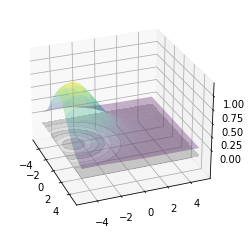

In [3]:
fig=plt.figure()
axes = fig.add_subplot(1,1, 1,projection='3d')
plot_food_pile(axes)

## Create physics model (ant's walking behaviour)

Next we create a simple physics model by which an ant can walk around.  In its basic form, the state of the ant is simply its position:

    state=(x,y)

and the "action" it takes is a movement vector:

    action=(vx,vy)

and the physics model is simply to move the ant by:

    new_state=state+action*speed

where $speed=0.2$ is arbitrarily chosen.


So that's pretty simple.  Later we'll add a bit more complexity to the physics model.


Also, we need to give the ant some "reward" signals.  At each time step $t$, with position $(x,y)$, we'll let the ant receive $food\_density(x,y)$ as part of its cumulative reward.



In [4]:
num_memory_nodes = 6 # TODO CHALLENGE2 (step3), edit this line
state_dimension = 9  # TODO CHALLENGE2 (step2+step3), edit this line --> 


initial_state=tf.concat([tf.constant( (np.random.rand(batch_size,2)-0.5)*10, tf.float32), tf.zeros([batch_size, state_dimension-2],tf.float32)],axis=1)

    
def sensor_calculation(pos):
    sensor_result = food_density(pos, food_location)
    sensor_result = tf.reshape(sensor_result,[batch_size,1])  # reshape it to a rank-2 tensor
    return sensor_result
    
def run_one_step_of_physics_model(state, action):
    '''
    State
    '''
    pos_xy = state[:, 0:2]
    '''
    Action
    '''
    vel_xy = action[:, 0:2]
    
    next_pos_xy = pos_xy + vel_xy * 0.2
    memory_action=action[:, 2:8]
    next_state_list=[next_pos_xy]
    
    # TODO CHALLENGE2 (step2+step3), start of code block in which to insert lines here to use the sensor
    # and memory.  Note for sensor functionality we have the sensor_calculation function above to call upon.
    # Use next_state_list.append(...) to add new chunks of the tensor you are building up
    sensor=sensor_calculation(next_pos_xy)
    next_state_list.append(sensor)
    next_state_list.append(memory_action)

    
    # END of code block in which to insert lines for CHALLENGE 2
    
    next_state = tf.concat(next_state_list, axis=1) # appends the rank-2 tensors in next_state_list side-by-side into one rank-2 tensor
    rewards = food_density(next_state[:,0:2], food_location)
    return [rewards, next_state]


## Build the ant "brain" (a neural controller)

Next define the ant's "brain".  This will be a simple feed-forward neural network that takes as input the current "state" of the ant, and produces an output "action".

In [5]:
from tensorflow import keras
from tensorflow.keras import layers



# TODO CHALLENGE2 (step2), modify the following 2 lines/insert new lines here to add extra inputs and outputs to the action network.  
action_network_num_inputs = 9  # x,y, sense, 6 memorie nodes
action_network_num_outputs = 8  # vx,vy, 6 memory nodes

class AntBrain(keras.Model):
    def __init__(self):
        super(AntBrain, self).__init__()
        self.layer1=layers.Dense(6, activation='tanh', input_shape=(action_network_num_inputs,))
        self.layer2=layers.Dense(6, activation='tanh')
        self.output_layer=layers.Dense(action_network_num_outputs, activation='tanh')
    
    @tf.function
    def call(self, input_vector):
        x=input_vector
        y=self.layer1(x)
        x=tf.concat([x,y], axis=1)# This adds shortcut connections from the previous layer to the next layer
        y=self.layer2(x)
        x=tf.concat([x,y], axis=1)# More shortcut connections.
        y=self.output_layer(x)
        # Using the shortcut connections above means I don't need to worry 
        # too much about how many hidden layers to add.  For example, if hidden 
        # layers 1 and 2 are not needed then they can simply be skipped over.
        # Also it ensures there are shortcut connections from the input layer to the final layer, which
        # potentially allows memories in memory cells to be preserved better.
        return y

keras_ant_brain=AntBrain()

## Evaluate full trajectories

Next define a python loop which can calculate a trajectory based on the start position and the decisions that the ant brain makes, using the one-step physics model function.  

- We also make it add up all of the rewards accumulated along the trajectory.
- We'll use a fixed trajectory length of 30

In [6]:
trajectory_length=30
@tf.function
def expand_full_trajectory(keras_ant_brain, start_states, food_location):
    total_rewards=tf.constant(0.0, dtype=tf.float32, shape=[batch_size]) 
    state=start_states # this is shape [batch_size, state_dimension]
    trajectory_list=[start_states]

    # build main graph.  This is a long graph with unrolled in time for trajectory_length steps.  Each step includes one neural network followed by one physics-model
    for time_step in range(trajectory_length):
        action = keras_ant_brain(state)
        [rewards,state]=run_one_step_of_physics_model(state,action)
        total_rewards+=rewards # This is shape [batch_size]
        trajectory_list.append(state)

    trajectories=tf.stack(trajectory_list) # This will be shape [batch_size, trajectory_length+1, state_dimension]
    average_total_reward=tf.reduce_mean(total_rewards) # this is a scalar
    return [average_total_reward,trajectories]

Next let's try to evaluate the trajectories, and plot them.

In [7]:
from IPython import display

def show_trajectories(trajectories, initial_state, food_location, iteration_number, reward, fig0):
    if fig0!=None:
        plt.close(fig0)
    display.clear_output(wait=True)
    fig=plt.figure(figsize=[12.4, 4.8])
    axes_2d=fig.add_subplot(1,2, 1)
    axes_2d.axis([-6,6,-6,6])
    colcycle=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    for traj in range(batch_size):
        axes_2d.scatter(food_location[traj,0],food_location[traj,1],marker="x", c=colcycle[traj])
        axes_2d.scatter(initial_state[traj,0],initial_state[traj,1],marker="o", c=colcycle[traj])
    for traj in range(batch_size):
        trajectory_x=trajectories[:,traj,0]
        trajectory_y=trajectories[:,traj,1]
        axes_2d.plot(trajectory_x, trajectory_y,'-', label='Traj1',c=colcycle[traj])
    axes_2d.grid(True)
    axes_2d.set_title('2d view.')
    
    if not(randomise_food_location):
        # since there is only one food location, we can do a 3d plot too
        axes_3d=fig.add_subplot(1,2, 2,projection='3d')
        plot_food_pile(axes_3d)
        for traj in range(batch_size):
            trajectory_x = trajectories[:, traj, 0]
            trajectory_y = trajectories[:, traj, 1]
            tZ=food_density(trajectories[:, traj, 0:2],food_location[traj:traj+1, :])
            axes_3d.plot(trajectory_x, trajectory_x,tZ , c=colcycle[traj])
        axes_3d.set_title('3d view')
    fig.suptitle("Iteration "+str(iteration_number)+". Reward "+str(reward))
    if fig0!=None:
        display.display(plt.gcf())
    return fig

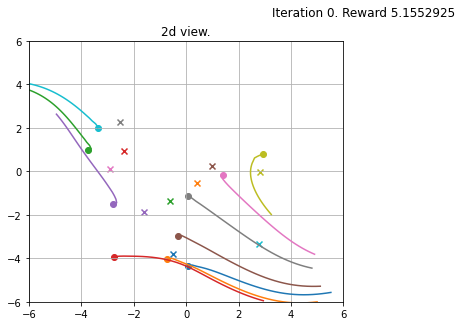

In [8]:
[average_total_reward,trajectories] = expand_full_trajectory(keras_ant_brain, initial_state, food_location)
fig=None
fig=show_trajectories(trajectories, initial_state, food_location,0, average_total_reward.numpy(), fig)

The ant brain is untrained so far, so the above trajectories don't find their targets well at all yet.

In [9]:
reward_history=[] # Keep a log for plotting training history

## Challenge 1: Train the ant brain so that the ant walks to the top of the food mountain

We'll need a custom training loop to train this ant, since it doesn't fall into the normal Keras pattern of having a "labels" output tensor.

**Objective:** Make each ant walk to the top of the hill.  

1. Fix the training loop below so that the loss is defined correctly, so that minimising loss acts to maximise the total trajectory reward.  

**Hint:** Look for the "TODO CHALLENGE1" line, in the code block below, and don't edit anywhere else.

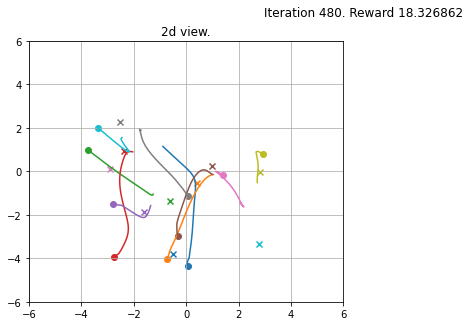

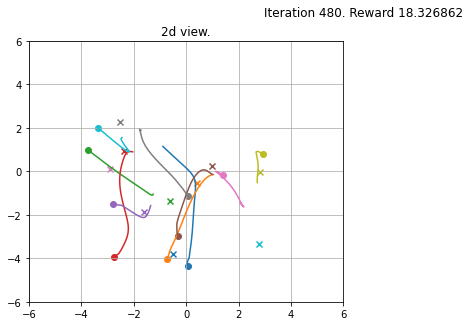

In [10]:
optimizer = keras.optimizers.Adam()


for i in range(1,500):
    with tf.GradientTape() as tape:

        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.
        [average_total_reward,trajectories] = expand_full_trajectory(keras_ant_brain, initial_state, food_location)
        print
        loss=-average_total_reward # TODO CHALLENGE1, edit this line to something sensible
        
    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.
    grads = tape.gradient(loss, keras_ant_brain.trainable_weights) # The "back-propagation through time" calculation is the computation of this gradient

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    optimizer.apply_gradients(zip(grads, keras_ant_brain.trainable_weights))

    if np.any(np.isnan(trajectories.numpy())):
        print("trajectory",trajectories)
        raise Exception("Trajectories is Nan")
        
    average_total_reward=average_total_reward.numpy()
    reward_history.append(average_total_reward)
    if (i%20)==0: 
        fig=show_trajectories(trajectories, initial_state, food_location, len(reward_history), average_total_reward, fig)

View training history...

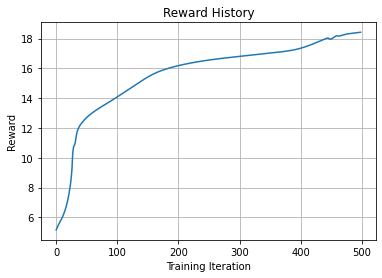

In [11]:
fig, ax = plt.subplots()
ax.set(xlabel='Training Iteration', ylabel='Reward', title='Reward History')
ax.grid(True)
ax.plot(reward_history)

### Did you solve it?

This is what you should be aiming to achieve in challenge 1:
![fixed_food_location_learning_goal.png](images/fixed_food_location_learning_goal.png)


- Notice that each trajectory converges to a single point at 0,0, the top of the food pile
- The total reward acheivable is $\approx$25
    - Note that the optimal reward of $\approx 25$ could be calculated numerically, as the sum of the food consumed along each optimal ant-path.  An optimal ant path is presumably a straight line, walking as fast as possible, from the ant's start position to the food peak (0,0), followed by the ant standing stationary at the top of the hill until the trajectory-time runs out.

# Challenge 2:  Adding sensor and memory

In this extension problem, we will make the ant learn to "look" for the food.

 - Perform the following 3 steps one-by-one:
 - Hint: Only edit lines near "TODO CHALLENGE2" comments to solve this challenge.
 - Hint: When you edit a lower-down code block, don't forget to re-run all code blocks from the top again.

1. Set randomise_food_location=True in the top code block above.  Then re-run all the code blocks in this page.  

    - The randomised food locations means each ant (each trajectory) has a different food location to aim for.  Hence the problem cannot be solved by the ants yet.   

    - Obviously this is now a harder problem than before.  Previously each ant could just assume the food was located at (0,0).  Now the food location is randomised- so the ants don't know where to go.   

    - In the next steps, we will upgrade each ant by giving it some sensory information, and allow it to learn some kind of algorithm to explore.
    

2. To help the ant "sense" where the food is, we give the ant a sensory input, which tells the ant how high the food pile is at its current position.  This sense will hopefully allow the ant to "sniff out" where most of the food is.

    - **Programming Instructions** 
        - Alter the function "run_one_step_of_physics_model" so that it adds the sensor information as an *extra input* into the state vector, and therefore into ant brain's neural network.  This will enable the ant to "see"; although "vision" here is a single scalar input.
        - Hint: you can use next_state_list.append(...) to build up the components of the next_state..     
        - Increase the size of the state_dimension and action_network_num_inputs by 1 to allow for this extra input.
        - Make sure initial_state is the full width of your new state_dimension
    - Get this step and these changes compiling successfully and run the whole series of scripts to test this stage before you go any further.  This change alone should improve the performance.
    

3. Because the food direction is a vector, but the sensor only outputs a scalar, we need to give the ant some *memory*.  This will allow the ant to choose an intelligent walking strategy to try to optimise the route to the top.  

    - **Programming Instructions** 
        - Set $num\_memory\_nodes=6$.  This is enough memory to solve this problem.  
        - Alter the ant brain so that the action network outputs an extra $num\_memory\_nodes$ outputs, and receives an extra $num\_memory\_nodes$ inputs.  These will act as recurrent memory nodes.  (The goal is to change the feed-forward NN into a recurrent NN.).  All we need to do in this step is to increase the variables $action\_network\_num\_inputs$ and $action\_network\_num\_outputs$ appropraitely.
        - Alter the function "run_one_step_of_physics_model" so that those memory nodes from the action vector get sliced out and appended to the next state vector.  This will mean the memory nodes outputted from the neural network (i.e. the action vector) will be fed back as part of the next input to the action network (i.e. that is the recurrence happening.  Note:  Do NOT add any extra keras RNN layers such as SimpleRNN or LSTM!)
        - Hints: To slice information out of the action vector you can use "action[:, start:end]"

### Did you solve it?

This is what we are aiming for in challenge 2.  
![randomised_food_location_learning_goal.png](images/randomised_food_location_learning_goal.png)

- Notice that each trajectory starts at a different location (the round dots, in a unique colour for each trajectory)
- Note that each trajectory bends towards the top of its own food mountain (i.e. towards its own coloured "x" point):
- A good total reward to achieve for this challenge is anything over 23.3

- Note that the 3d plot doesn't make as much sense now, so we have omitted it.

## Reflections - Meta Learning

- Note this is a meta learning objective here - we are training the RNN (the outer learning objective) to be able to interact and make deductions about an environment, while walking, and after the weight-training has ended.  That "learning while walking" is the inner learning objective.

- Also, this page introduces you to neurocontrol, or Adaptive Dynamic Programming (ADP).  ADP is closely related to reinforcement learning, but ADP allows you to access and differentiate through the physics model, as we have done in this example.